<a href="https://colab.research.google.com/github/fatemehes75/Detection-the-potential-frauds/blob/main/Credit_Card_Fraud_Detection_using_Autoencoders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Anomaly Detection in Credit Card Transactions using Autoencoders**

This project focuses on implementing an anomaly detection system for credit card transactions using Autoencoder Neural Networks. Anomaly detection plays a crucial role in identifying unusual patterns or behaviors that may indicate fraudulent activities. By leveraging the power of deep learning and unsupervised learning, this project demonstrates a method to automatically detect anomalies in credit card transactions.

**Data Loading and Exploration:**

* The project begins by loading a credit card transaction dataset containing both normal and fraudulent transactions.
* I explored the dataset's distribution, visualize transaction amounts, and analyze class distribution to understand the dataset's characteristics.

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf
import seaborn as sns
from pylab import rcParams
from sklearn.model_selection import train_test_split
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers
%matplotlib inline
sns.set(style='whitegrid', palette='muted', font_scale=1.5)
rcParams['figure.figsize'] = 14, 8
RANDOM_SEED = 42
LABELS = ["Normal", "Fraud"]

In [3]:
# Load the dataset
df = pd.read_csv("creditcard.csv")

In [4]:
# Check the shape of the dataset
print(df.shape)  # Output: (284807, 31)

(284807, 31)


Data Wrangling

In [5]:
# Check for missing values
print(df.isnull().values.any())  # Output: False

False


EDA

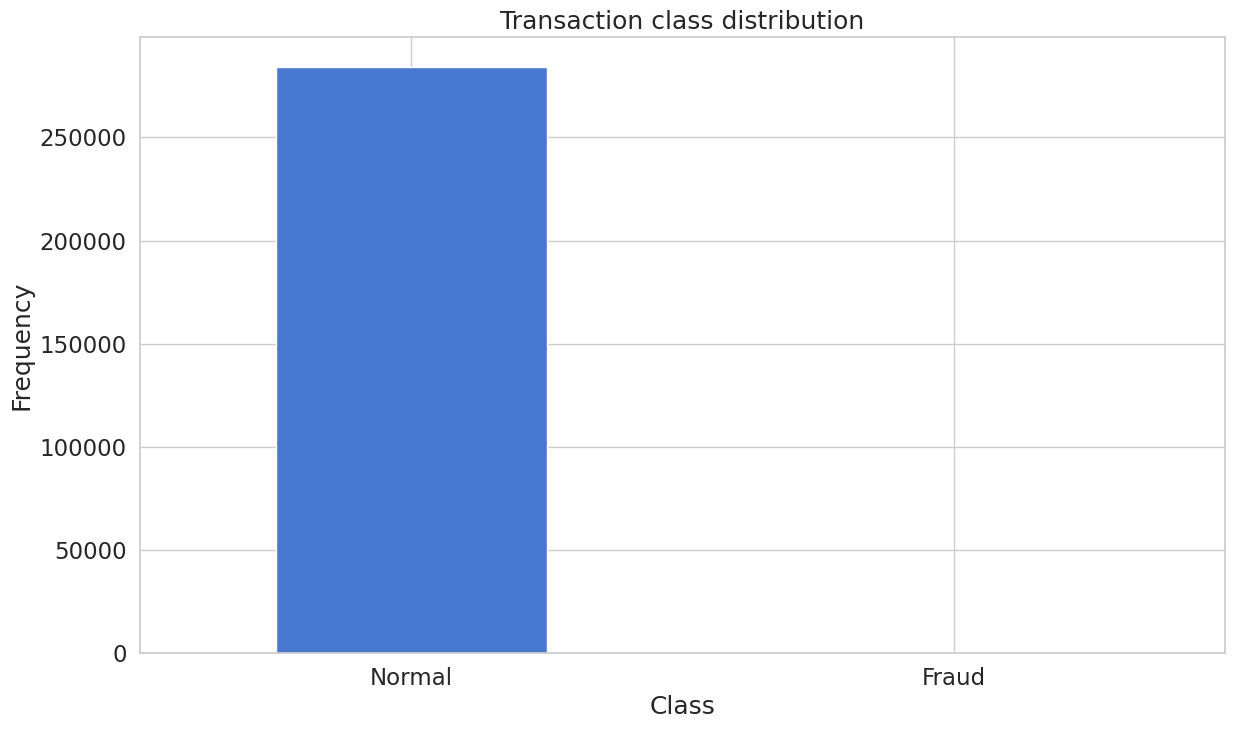

In [6]:
# Visualize class distribution
count_classes = pd.value_counts(df['Class'], sort=True)
count_classes.plot(kind='bar', rot=0)
plt.title("Transaction class distribution")
plt.xticks(range(2), LABELS)
plt.xlabel("Class")
plt.ylabel("Frequency")
plt.show()

In [7]:
# Separate normal and fraudulent transactions
frauds = df[df.Class == 1]
normal = df[df.Class == 0]
print(frauds.shape)  # Output: (492, 31)
print(normal.shape)  # Output: (284315, 31)

(492, 31)
(284315, 31)


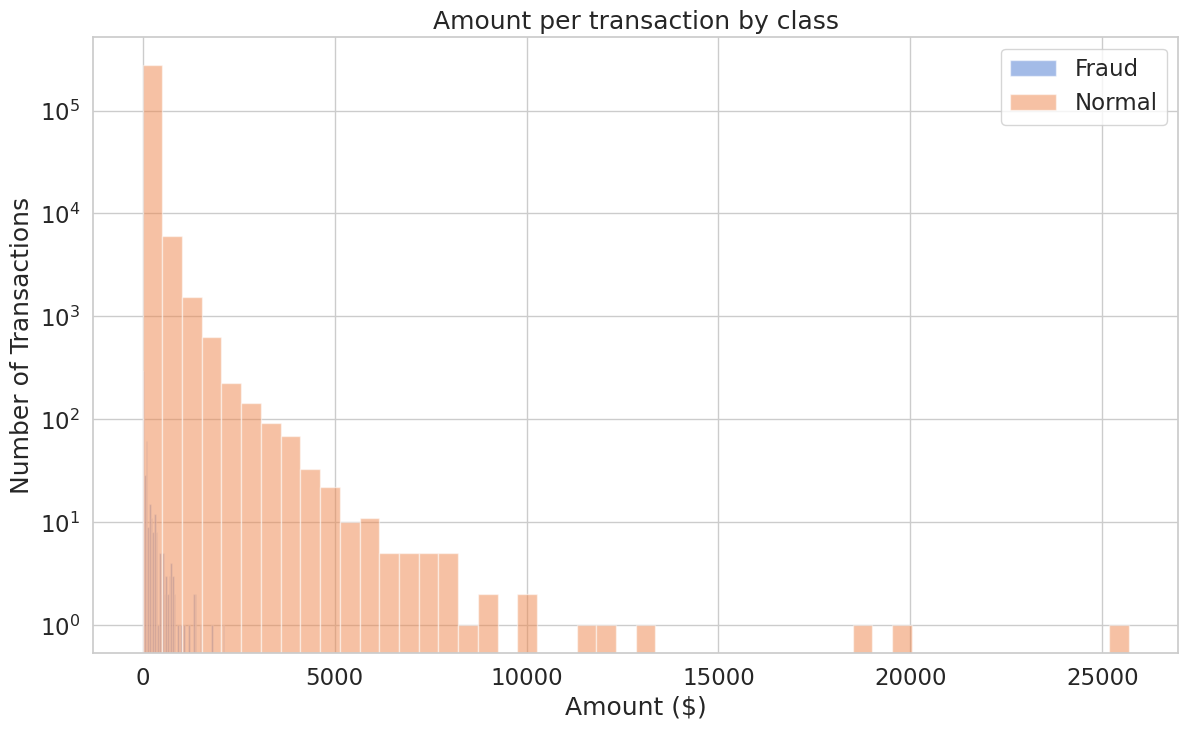

In [8]:
# Visualize transaction amounts for different classes
plt.hist(frauds.Amount, bins=50, alpha=0.5, label='Fraud')
plt.hist(normal.Amount, bins=50, alpha=0.5, label='Normal')
plt.title('Amount per transaction by class')
plt.xlabel('Amount ($)')
plt.ylabel('Number of Transactions')
plt.yscale('log')
plt.legend(loc='upper right')
plt.show()

We can drop columns that have no effect on predictive analysis.

In [9]:
# Preprocess the data
data = df.drop(['Time'], axis=1)
from sklearn.preprocessing import StandardScaler
data['Amount'] = StandardScaler().fit_transform(data['Amount'].values.reshape(-1, 1))

**Autoencoders for Anomaly Detection:**

* Autoencoders, a type of neural network, are introduced as a powerful tool for anomaly detection.
* The concept of reconstruction error is explained, where the model aims to reconstruct input data while minimizing the error.

In [10]:
# Split the data into training and testing sets, using only normal transactions for training
X_train, X_test = train_test_split(data, test_size=0.2, random_state=RANDOM_SEED)

X_train = X_train[X_train.Class == 0]
X_train = X_train.drop(['Class'], axis=1)

y_test = X_test['Class']
X_test = X_test.drop(['Class'], axis=1)

X_train = X_train.values
X_test = X_test.values

In [11]:
# Build the Autoencoder model
input_dim = X_train.shape[1]
encoding_dim = 14

input_layer = Input(shape=(input_dim,))
encoder = Dense(encoding_dim, activation="tanh", activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoder = Dense(int(encoding_dim / 2), activation="relu")(encoder)
decoder = Dense(int(encoding_dim / 2), activation='tanh')(encoder)
decoder = Dense(input_dim, activation='relu')(decoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)

In [12]:
# Compile the model
autoencoder.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

In [13]:
# Define callbacks for saving best model and TensorBoard
checkpointer = ModelCheckpoint(filepath="model.h5", verbose=0, save_best_only=True)
tensorboard = TensorBoard(log_dir='./logs', histogram_freq=0, write_graph=True, write_images=True)

In [14]:
# Train the model
nb_epoch = 100
batch_size = 32
history = autoencoder.fit(X_train, X_train,
                          epochs=nb_epoch,
                          batch_size=batch_size,
                          shuffle=True,
                          validation_data=(X_test, X_test),
                          verbose=1,
                          callbacks=[checkpointer, tensorboard]).history

Epoch 1/100
7108/7108 [==============================] - 23s 3ms/step - loss: 0.8127 - accuracy: 0.5873 - val_loss: 0.7843 - val_accuracy: 0.6739
Epoch 2/100
7108/7108 [==============================] - 30s 4ms/step - loss: 0.7424 - accuracy: 0.6798 - val_loss: 0.7648 - val_accuracy: 0.6917
Epoch 3/100
7108/7108 [==============================] - 19s 3ms/step - loss: 0.7289 - accuracy: 0.6976 - val_loss: 0.7575 - val_accuracy: 0.7047
Epoch 4/100
7108/7108 [==============================] - 19s 3ms/step - loss: 0.7230 - accuracy: 0.7062 - val_loss: 0.7525 - val_accuracy: 0.7164
Epoch 5/100
7108/7108 [==============================] - 24s 3ms/step - loss: 0.7191 - accuracy: 0.7088 - val_loss: 0.7497 - val_accuracy: 0.7132
Epoch 6/100
7108/7108 [==============================] - 20s 3ms/step - loss: 0.7162 - accuracy: 0.7102 - val_loss: 0.7449 - val_accuracy: 0.7147
Epoch 7/100
7108/7108 [==============================] - 20s 3ms/step - loss: 0.7135 - accuracy: 0.7084 - val_loss: 0.7447 -

In [15]:
# Load the best model
autoencoder = load_model('model.h5')

In [16]:
# Calculate reconstruction error and create an error dataframe
predictions = autoencoder.predict(X_test)
mse = np.mean(np.power(X_test - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse, 'true_class': y_test})

1781/1781 [==============================] - 3s 1ms/step


Evaluation

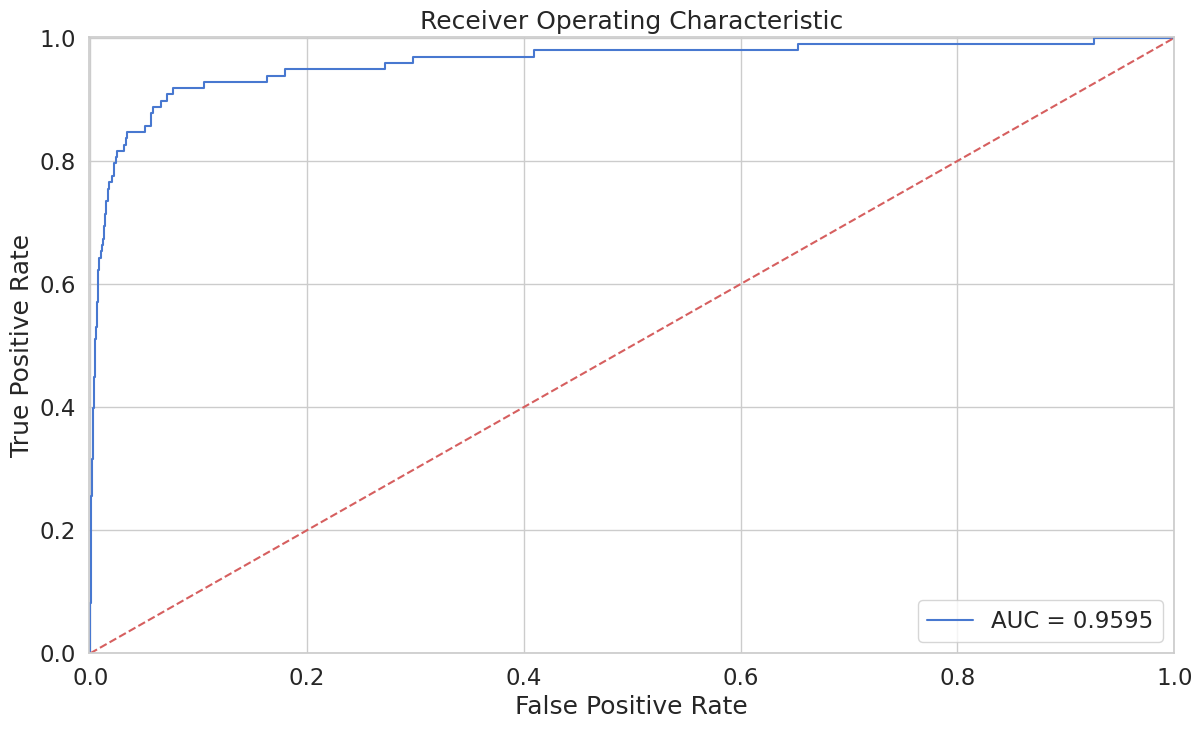

In [17]:
# Evaluate the ROC curve
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(error_df.true_class, error_df.reconstruction_error)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label='AUC = %0.4f' % roc_auc)
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.show()

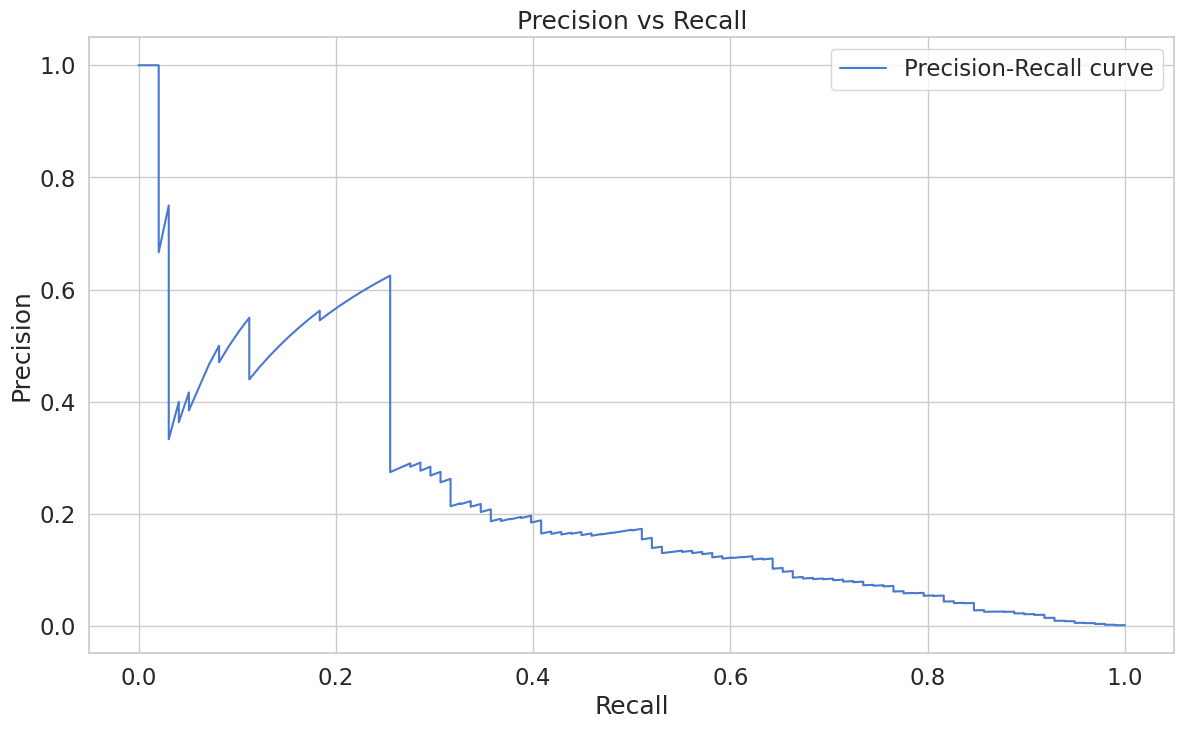

In [18]:
# Evaluate Precision vs Recall
from sklearn.metrics import precision_recall_curve
precision, recall, th = precision_recall_curve(error_df.true_class, error_df.reconstruction_error)
plt.plot(recall, precision, 'b', label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision vs Recall')
plt.legend(loc='best')
plt.show()

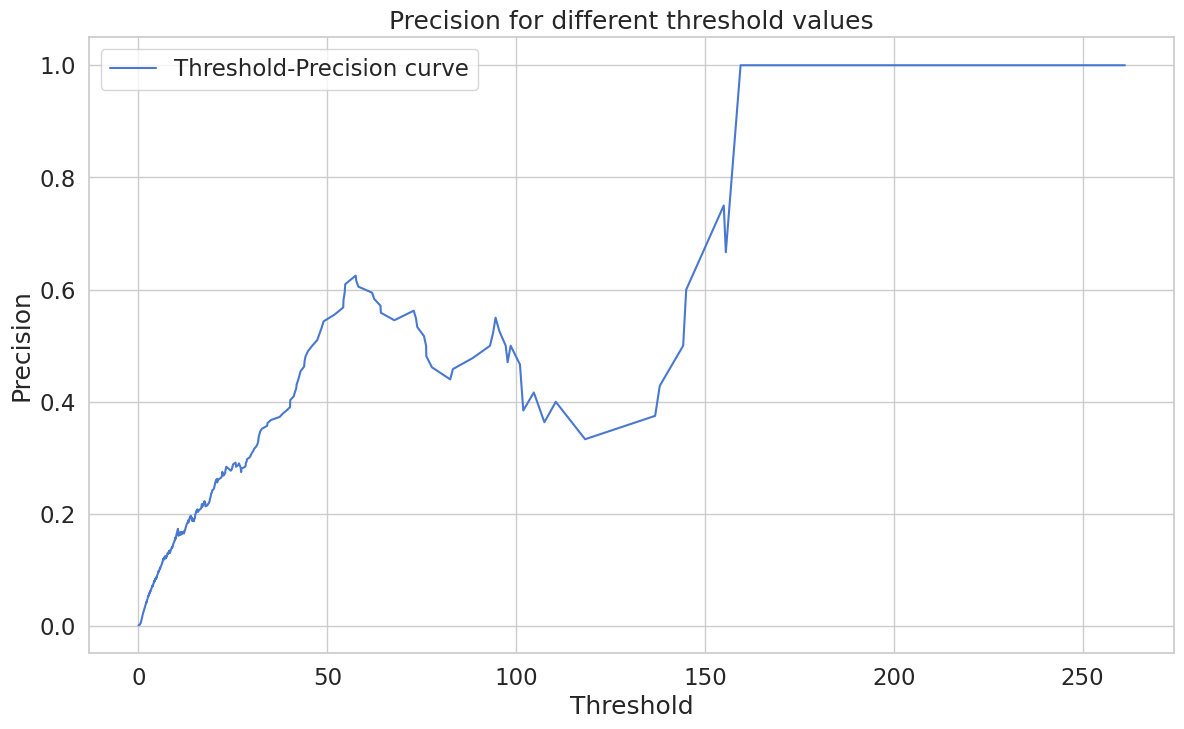

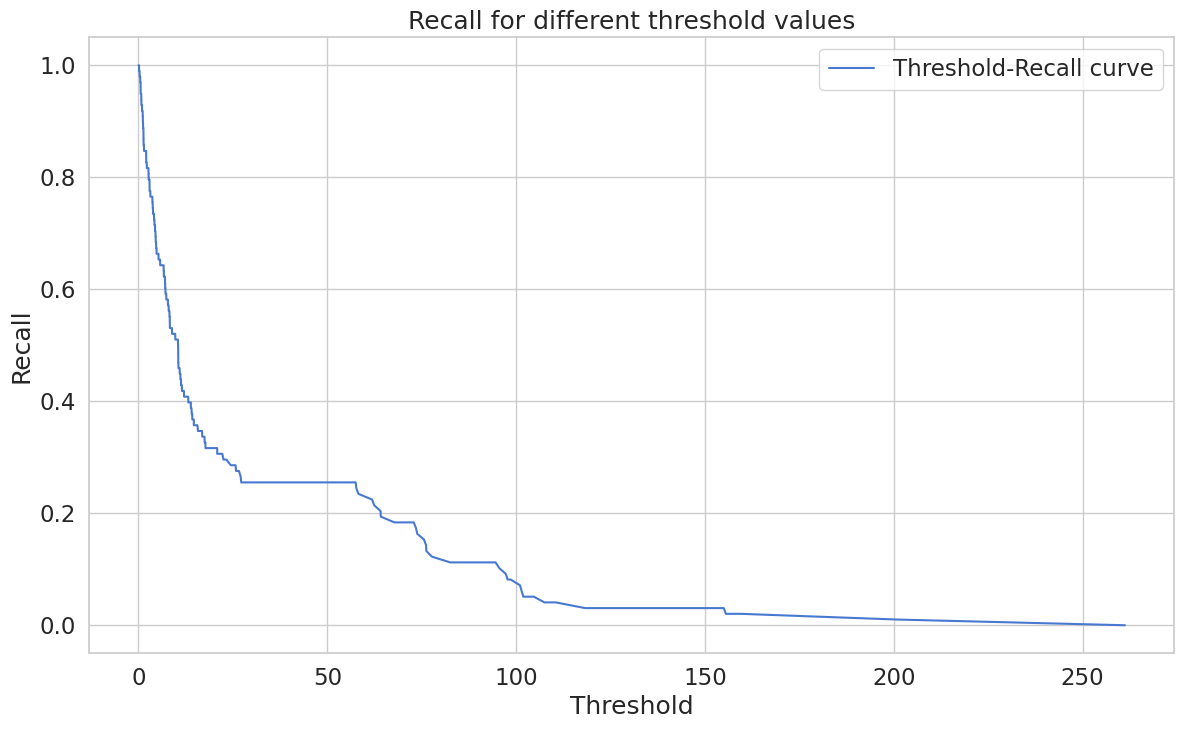

In [19]:
# Evaluate Precision and Recall for different threshold values
plt.plot(th, precision[1:], 'b', label='Threshold-Precision curve')
plt.xlabel('Threshold')
plt.ylabel('Precision')
plt.title('Precision for different threshold values')
plt.legend(loc='best')
plt.show()

plt.plot(th, recall[1:], 'b', label='Threshold-Recall curve')
plt.xlabel('Threshold')
plt.ylabel('Recall')
plt.title('Recall for different threshold values')
plt.legend(loc='best')
plt.show()

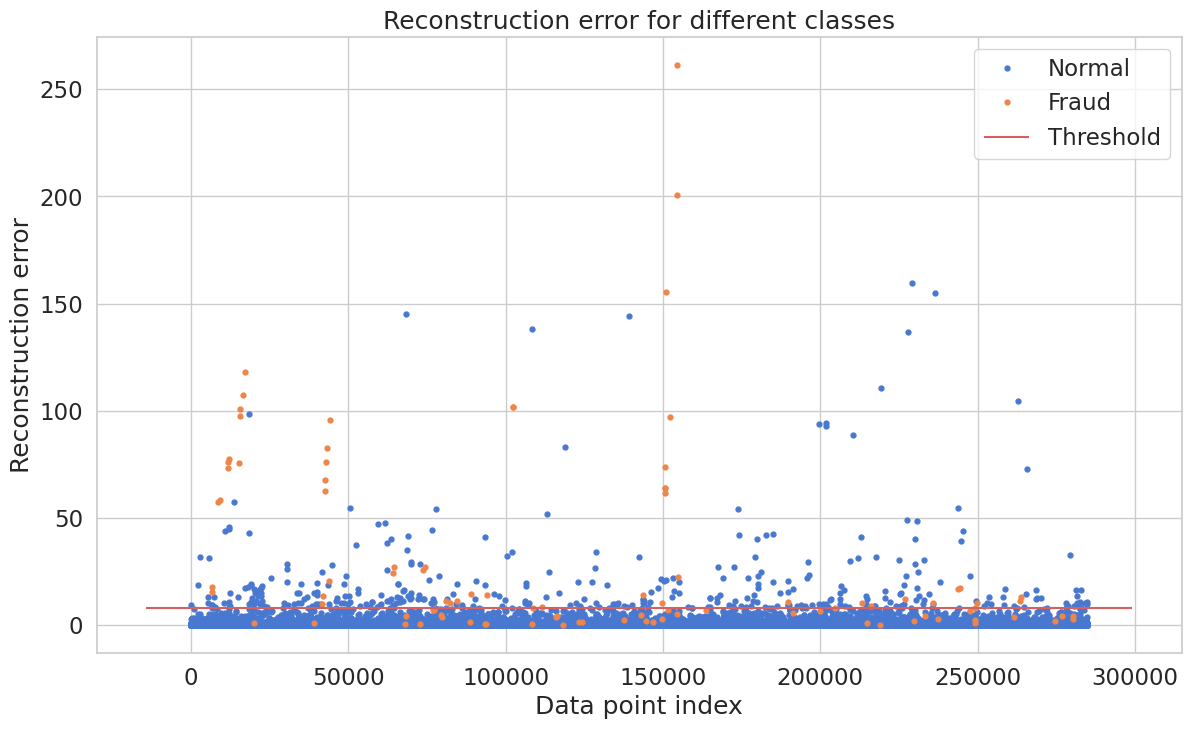

In [28]:
# Set a threshold for classification
threshold = 8

# Visualize the reconstruction error with the threshold
groups = error_df.groupby('true_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.reconstruction_error, marker='o', ms=3.5, linestyle='',
            label="Fraud" if name == 1 else "Normal")
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show()

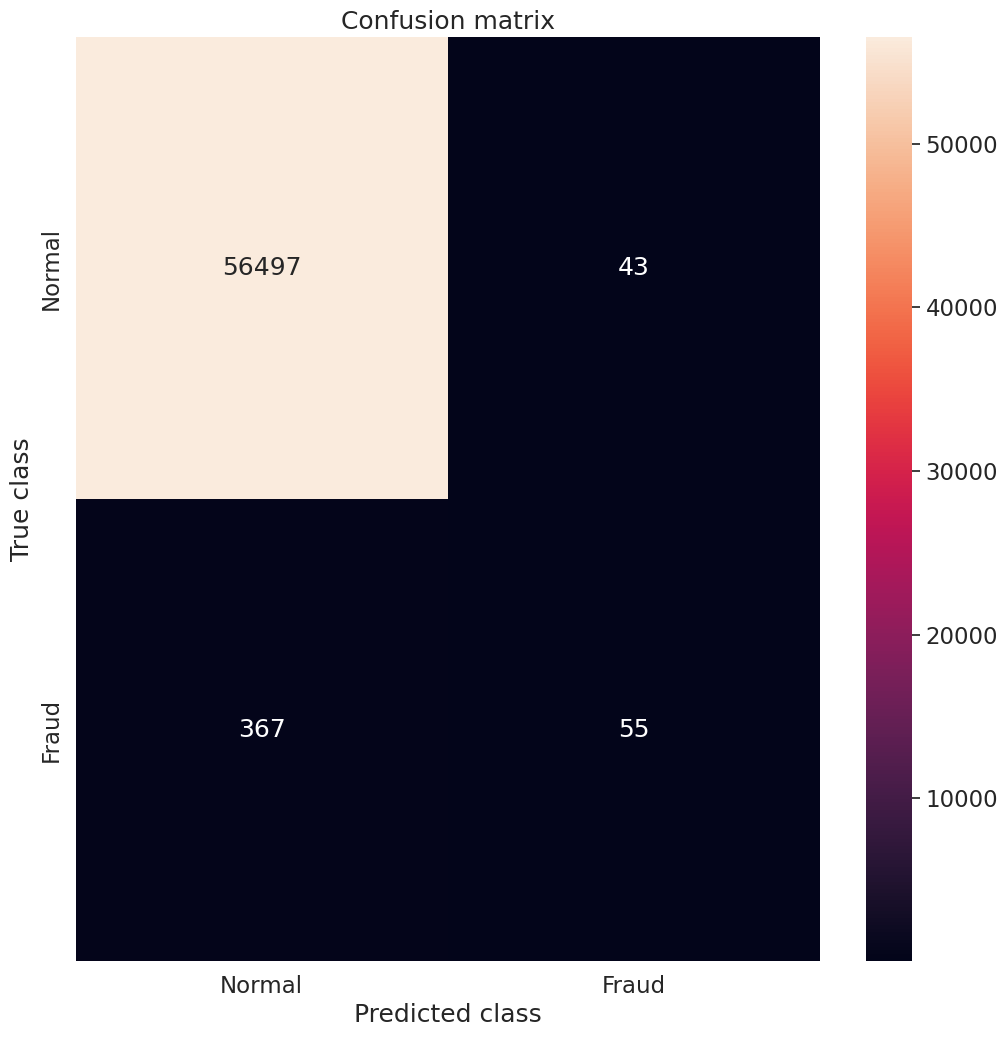

In [29]:
# Use the threshold to classify transactions
from sklearn.metrics import confusion_matrix
y_pred = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix( y_pred,error_df.true_class)

# Plot the confusion matrix
plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d")
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()


We can increase or decrease the value of the threshold.
* If threshold is small, the number of transactions that are originally **Normal**, but are predicted as **Fraud** will increase, so FN(false negative) will increase.
* If threshold is big, the number of transactions that are originally **Fraud**, but are predicted as **Normal** will increase, so FP(false positive) will increase.